In [9]:
import pandas as pd

# Load dataset
df = pd.read_csv("./datasets/bike_data.csv", index_col=0)

In [10]:
# Copy this to other notebooks to get the train and test data
def load_train_test():
    train_df = pd.read_csv("./datasets/bike_train.csv", index_col=0)
    test_df = pd.read_csv("./datasets/bike_test.csv", index_col=0)
    X_train = train_df.drop("Count", axis=1).values
    y_train = train_df["Count"]
    X_test = test_df.drop("Count", axis=1).values
    y_test = test_df["Count"]
    return (X_train, X_test, y_train, y_test)

## Train Test Split

In [11]:
X_train, X_test, y_train, y_test = load_train_test()

## Random Forest Models

### Random Forest Basic


In [12]:
from sklearn.metrics import r2_score

# Linear Regression Model basic
from sklearn.ensemble import RandomForestRegressor

LR = RandomForestRegressor(n_jobs=-1)

reg = LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
print("R2 score for random forest: ", r2_score(y_test, y_pred))

R2 score for random forest:  0.9080368629533134


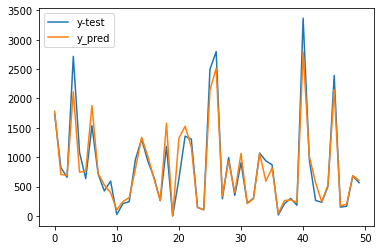

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
N = 50

plt.plot(list(y_test[:N]), label="y-test")
plt.plot(list(y_pred[:N]), label="y_pred")
plt.legend()
plt.show()

### Random Forest Variations


In [14]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {  
            'max_features': range(1,22, 4),
            'ccp_alpha': np.linspace(0, 0.04, 5)
} 
grid = GridSearchCV(RandomForestRegressor(), param_grid, verbose=3)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print("R2 score for random forest (with grid search): ", r2_score(y_test, y_pred))

0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.902, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.920, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.915, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.906, total=   1.2s
[CV] ccp_alpha=0.0, max_features=9 ...................................
[CV] ....... ccp_alpha=0.0, max_features=9, score=0.911, total=   1.2s
[CV] ccp_alpha=0.0, max_features=13 ..................................
[CV] ...... ccp_alpha=0.0, max_features=13, score=0.910, total=   1.5s
[CV] ccp_alpha=0.0, max_features=13 ..................................
[CV] ...... ccp_alpha=0.0, max_features=13, score=0.919, total=   1.5s
[CV] ccp_alpha=0.0, max

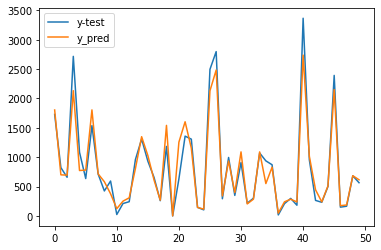

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
N = 50

plt.plot(list(y_test[:N]), label="y-test")
plt.plot(list(y_pred[:N]), label="y_pred")
plt.legend()
plt.show()

## Model Persistence

In [16]:
from joblib import dump, load
dump(LR, './models/random_forest.joblib') 

['./models/random_forest.joblib']